In [1]:
from numpy_sugar.linalg import economic_qs, economic_qs_linear
from numpy.random import RandomState, default_rng
from numpy import arange, concatenate, newaxis, median, asarray
from glimix_core.lmm import LMM
from scipy.stats import chi2
from numpy_sugar import epsilon
from numpy import asarray, clip, inf, ones, sqrt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from struct_lmm2 import StructLMM2, create_variances, sample_phenotype_gxe

In [2]:
import struct_lmm2 # check that it refers to code in repo
struct_lmm2

<module 'struct_lmm2' from '/hps/nobackup/stegle/users/acuomo/git_repos/struct-lmm2/struct_lmm2/__init__.py'>

In [3]:
def _symmetric_decomp(H):
    # H = L @ L.T
    # Returns L
    [U, S, _] = economic_svd(H)
    L = ddot(U, sqrt(S))
    return L

In [5]:
random = default_rng(20)

n_individuals = 100

maf_min = 0.40
maf_max = 0.45

n_snps = 100
# n_snps = 500

# n_cells = 100
# n_cells = 10
# n_cells = 2
n_cells = arange(n_individuals) + 1

n_env_groups = 10
offset = 0.3

# indices of causal SNPs
g_causals = [5, 6]
gxe_causals = [10, 11]

# weight of genetic variance explained by GxE
r0 = 0.5
# r0 = 0
# r0 = 1

# total variance explained by genetics (G + GxE)
v0 = 0.5
# v0 = 0


v = create_variances(r0, v0)

In [6]:
s = sample_phenotype_gxe(
        offset=offset,
        n_individuals=n_individuals,
        n_snps=n_snps,
        n_cells=n_cells,
        n_env_groups=n_env_groups,
        
        maf_min=maf_min,
        maf_max=maf_max,
        g_causals=g_causals,
        gxe_causals=gxe_causals,
        variances=v,
        random=random,
    )

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


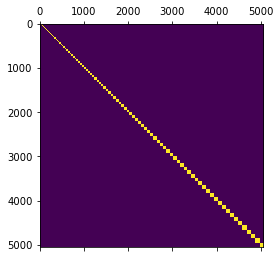

In [7]:
# kinship matrix (block diagonal)
# plot for few individuals to check if it looks good
plt.matshow(s.K)

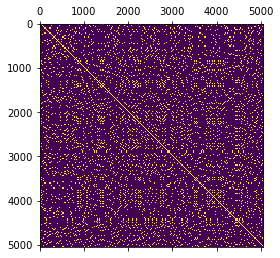

In [8]:
plt.matshow(s.E @ s.E.T)

In [9]:
# set up model
# covariates (just ones here)
M = ones((s.y.shape[0], 1))

In [10]:
y = s.y.reshape(s.y.shape[0],1)

In [11]:
slmm2 = StructLMM2(y, M, s.E, s.Ls)

In [12]:
pv = slmm2.scan_interaction(s.G)

100%|██████████| 100/100 [42:12<00:00, 25.33s/it]


In [13]:
p=pv[0]

In [14]:
# show p-values
# expected: 5,6 not sign (not testing for G); 10,11 significant (causal GxE); median of rest ~0.5 (from uniform distr)
print(p[5], p[6], p[10], p[11], median(p[12:]))

0.471458421788032 0.9484420357802292 1.2701111259392058e-30 2.5017330323932364e-30 0.8825650444273913
